In [27]:
import pandas as pd
import numpy as np  # numpy也是做数据处理比较常用的库，官方文档：https://numpy.org/
import tensorflow as tf  # 我们玩神经网络的库，官方网站：https://tensorflow.google.cn/
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import numpy as np

from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, SimpleRNN
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from joblib import dump, load

In [28]:
# 读数据
df = pd.read_csv('tmp8.csv')
df = df[29:].set_index(df['time'][29:]).drop(columns=['time', 'time'])  # 设置时间为索引，把含空值的与不必要的列去掉

# 设置训练集、验证集和测试集的比例为5：3：2
n = len(df)
train_split = int(0.5*n)
val_split = int(0.8*n)

df.head()

,open,close,high,low,diff,up,down,avg_up,avg_down,rsi,ema12,ema26,dif,mov_avg_ten,mov_avg_thirty,dea9,macd
time,,,,,,,,,,,,,,,,,
2009/2/20,17.16,17.57,17.58,17.09,0.41,0.41,0.00,0.333333,0.298333,52.770449,17.522988,16.655994,0.866994,17.998,16.206667,1.043946,-0.353905
2009/2/23,17.24,18.09,18.15,16.90,0.52,0.52,0.00,0.316667,0.298333,51.490515,17.610220,16.762217,0.848004,17.931,16.388000,1.004757,-0.313508
2009/2/24,17.69,17.00,17.98,16.93,-1.09,0.00,-1.09,0.173333,0.480000,26.530612,17.516340,16.779830,0.736510,17.750,16.493667,0.951108,-0.429196
2009/2/25,17.23,16.62,17.30,16.18,-0.38,0.00,-0.38,0.173333,0.460000,27.368421,17.378442,16.767991,0.610451,17.601,16.593000,0.882976,-0.545051
2009/2/26,16.64,15.95,17.15,15.63,-0.67,0.00,-0.67,0.173333,0.356667,32.704403,17.158681,16.707399,0.451282,17.460,16.675000,0.796638,-0.690711


In [29]:
df_mean = df[:train_split].mean(axis=0)  # 计算每个特征在训练集的均值备用，axis=0表示计算的是每个特征而不是每日各个特征的均值
df_std = df[:train_split].std(axis=0)  # 计算每个特征在训练集的标准差备用
df = (df - df_mean) / df_std  # 标准化

df = df.values
target = df[:, 1]

print(type(df))  # values后df的类型从DataFrame变成了ndarray，没有head()方法
print(df.shape)  # 计1245条数据，17个特征

<class 'numpy.ndarray'>
(2794, 17)


In [30]:
def window_generator(dataset, target, start_index, end_index, 
                     history_size, target_size):
    

    
    features = []
    labels = []
    
    if end_index is None:
        end_index = len(dataset) - target_size
    
    start_index += history_size
        
    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        features.append(dataset[indices])
        labels.append(target[i:i+target_size])
        
    return np.array(features), np.array(labels)

In [32]:
def loss_curve(history):
   
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(len(loss))
    
    plt.figure()
    
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

In [33]:
EPOCHS = 100  # 设置最大训练轮数为100轮
EVALUATION_INTERNAL = 120  # step per epoch

# 数据增强参数备用
BATCH_SIZE = 100
BUFFER_SIZE = 2000

In [34]:
def compile_and_fit(model, train_data, val_data, patience=10):
    
    """
    Define the process of compling and fitting the model.
    
    """
    
    # 为防止过拟合，监视验证集上的loss值，在10个epoch内没有发生太大变化则终止训练
    early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    verbose=1,
    patience=patience,
    mode='auto',
    restore_best_weights=True)  # 返回最优参数，而非训练停止时的参数
    
    # 模型编译
    model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0),  # 设置优化器
                 loss='mae')  # 设置损失函数
    
    # 模型拟合
    history = model.fit(train_data, epochs=EPOCHS,
                        steps_per_epoch=EVALUATION_INTERNAL,
                        validation_steps=50,
                        validation_data=val_data,
                        callbacks=[early_stopping])
    return history

In [35]:
X_train_single, y_train_single = window_generator(dataset=df, target=target, start_index=0,
                                                 end_index=train_split, history_size=1, target_size=1)

X_val_single, y_val_single = window_generator(dataset=df, target=target, start_index=train_split,
                                             end_index=val_split, history_size=1, target_size=1)

X_test_single, y_test_single = window_generator(dataset=df, target=target, start_index=val_split,
                                             end_index=n-1, history_size=1, target_size=1)

X_train_multi, y_train_multi = window_generator(dataset=df, target=target, start_index=0,
                                                 end_index=train_split, history_size=5, target_size=1)

X_val_multi, y_val_multi = window_generator(dataset=df, target=target, start_index=train_split,
                                             end_index=val_split, history_size=5, target_size=1)

X_test_multi, y_test_multi = window_generator(dataset=df, target=target, start_index=val_split,
                                              end_index=n-5, history_size=5, target_size=1)
print(X_train_multi.shape)
print(X_val_multi.shape)
print(X_test_multi.shape)

(1392, 5, 17)
(833, 5, 17)
(549, 5, 17)


In [36]:
train_single = tf.data.Dataset.from_tensor_slices((X_train_single, y_train_single))
val_single = tf.data.Dataset.from_tensor_slices((X_val_single, y_val_single))

train_multi = tf.data.Dataset.from_tensor_slices((X_train_multi, y_train_multi))
val_multi = tf.data.Dataset.from_tensor_slices((X_val_multi, y_val_multi))

train_single = train_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做
val_single = val_single.cache().batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做

train_multi = train_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做
val_multi = val_multi.cache().batch(BATCH_SIZE).repeat()  # 数据增强，shuffle只对训练集做

Epoch 1/100

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

120/120 [==============================] - 1s 5ms/step - loss: 0.0879 - val_loss: 0.0391
Epoch 2/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0618 - val_loss: 0.0601
Epoch 3/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0578 - val_loss: 0.0533
Epoch 4/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0558 - val_loss: 0.0265
Epoch 5/100
120/120 [==============================] - 0s 3ms/step - loss: 0.0544 - val_loss: 0.0582
Epo

<IPython.core.display.Javascript object>


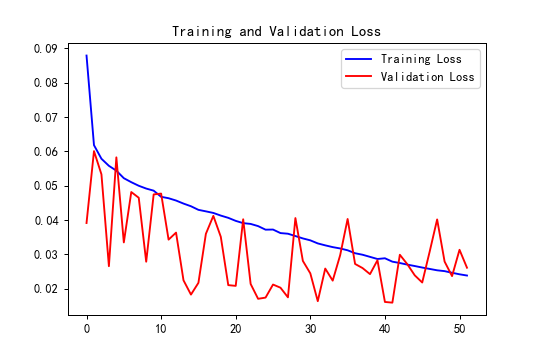

In [37]:
lstm = tf.keras.Sequential([
    tf.keras.layers.LSTM(50),
    tf.keras.layers.Dense(1)
])

lstm_history = compile_and_fit(lstm, train_multi, val_multi)
loss_curve(lstm_history)
lstm_result = lstm.predict(X_test_multi).reshape(-1, 1)

<IPython.core.display.Javascript object>


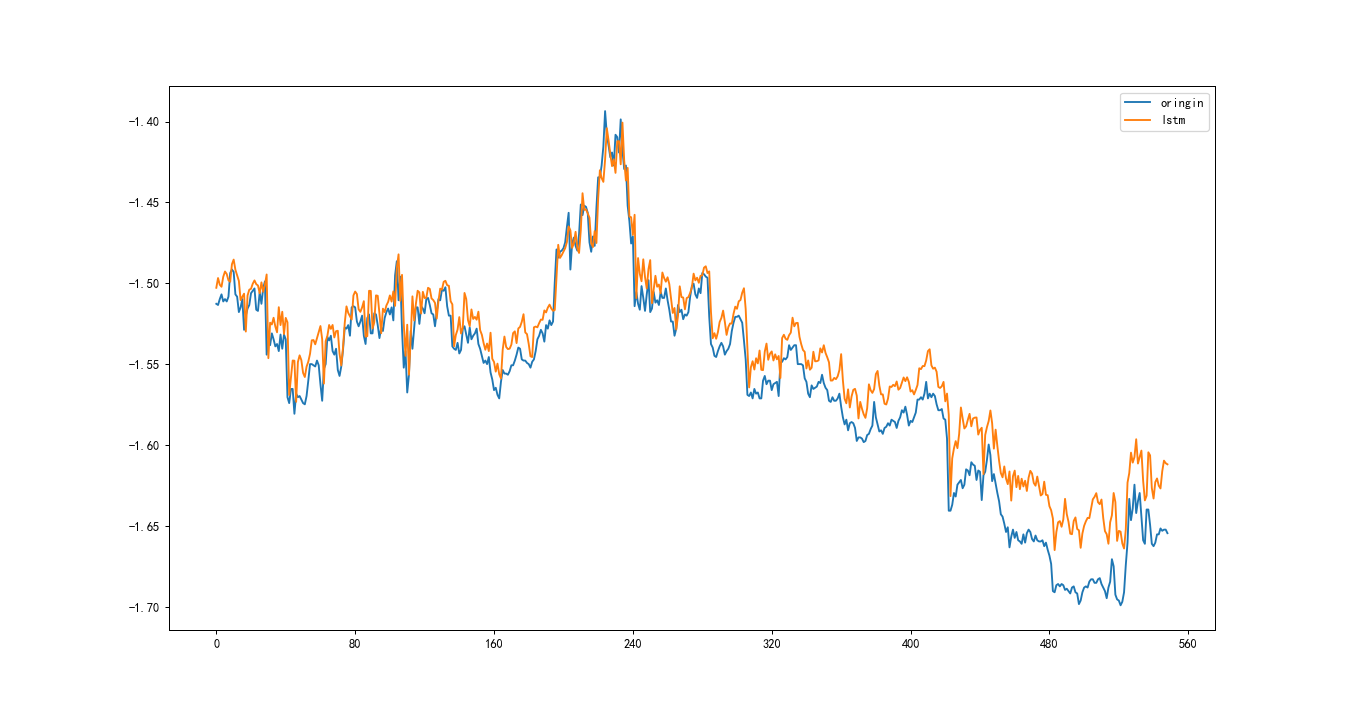

In [38]:
fig = plt.figure(figsize=(15, 8))
ax = plt.subplot2grid((3, 3), (0, 0), rowspan=3, colspan=3)
ax.xaxis.set_major_locator(mticker.MaxNLocator(10))

plt.plot(y_test_multi, label='oringin')
plt.plot(lstm_result, label='lstm')
plt.legend()

plt.show()